# The clinician impact and financial cost to the NHS of Pfizer’s court case over pregabalin

## The impact of the NHS England letter on prescribers in the NHS

In February 2015 an English Court ordered NHS England to write to all prescribers and pharmacists in England, advising that when pregabalin was prescribed for neuropathic pain (thought to be appoximately 70% of all prescriptions) the brand Lyrica should be prescribed, rather than the generic drug.

In order to assess the impact, we need to calculate whether GPs followed this guidance.

All data used in this Jupyter notebook is from OpenPrescribing.net's Google BigQuery database.  

In order to reduce costs and server overheads, a BigQuery table was created containing all prescribing data from the main prescribing database for the eight strengths of pregabalin capsules available in England, using partial BNF codes to find all brands and generic prescriptions:

* 0408010AE%AA - pregabalin 25mg capsules
* 0408010AE%AB - pregabalin 50mg capsules
* 0408010AE%AC - pregabalin 75mg capsules
* 0408010AE%AD - pregabalin 100mg capsules
* 0408010AE%AE - pregabalin 150mg capsules
* 0408010AE%AF - pregabalin 200mg capsules
* 0408010AE%AI - pregabalin 225mg capsules
* 0408010AE%AG - pregabalin 300mg capsules


### Obtaining data from BigQuery

In [1]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import  DateFormatter
%matplotlib inline

In [2]:
projectid = "ebmdatalab"
#obtain overall data for all CCG prescribing for pregabalin capsules
overall_df = pd.read_gbq("""
SELECT
  FORMAT_TIMESTAMP("%B %Y", pregabalin.month) as month_string,
  pregabalin.month as period,
  SUM(CASE
      WHEN SUBSTR(pregabalin.bnf_code,10,2)='BB' THEN items
      ELSE 0 END) AS lyrica_items,
  SUM(CASE
      WHEN SUBSTR(pregabalin.bnf_code,10,2)='AA' THEN items
      ELSE 0 END) AS generic_items,
  SUM(CASE
      WHEN SUBSTR(pregabalin.bnf_code,10,2) NOT IN ('AA', 'BB')THEN items
      ELSE 0 END) AS other_brand_items
FROM
ebmdatalab.richard.pregabalin_data AS pregabalin
INNER JOIN
  ebmdatalab.hscic.ccgs AS ccg
ON
  pregabalin.pct=ccg.code
WHERE
ccg.org_type = 'CCG'
GROUP BY
  period, month_string
ORDER BY
  period
""", projectid, dialect='standard')

Requesting query... ok.
Job ID: job_WKKxch6Xe_QLvm2E59JBmaPYv7EW
Query running...
Query done.
Cache hit.

Retrieving results...
Got 87 rows.

Total time taken 1.0 s.
Finished at 2017-12-19 15:21:05.


In [3]:
#obtain overall data for prescribing for pregabalin capsules at CCG level
ccg_df = pd.read_gbq("""
SELECT
  pregabalin.month as period,
  pregabalin.pct,
  SUM(CASE
      WHEN SUBSTR(pregabalin.bnf_code,10,2)='BB' THEN items
      ELSE 0 END) AS lyrica_items,
  SUM(CASE
      WHEN SUBSTR(pregabalin.bnf_code,10,2)='AA' THEN items
      ELSE 0 END) AS generic_items,
  SUM(CASE
      WHEN SUBSTR(pregabalin.bnf_code,10,2) NOT IN ('AA', 'BB')THEN items
      ELSE 0 END) AS other_brand_items,
  SUM(items) AS all_items,
  IEEE_DIVIDE(SUM(
      CASE
        WHEN SUBSTR(pregabalin.bnf_code,10,2)='BB' THEN items
        ELSE 0 END), SUM(items)) AS lyrica_percent,
  IEEE_DIVIDE(SUM(
      CASE
        WHEN SUBSTR(pregabalin.bnf_code,10,2) NOT IN ('AA', 'BB')THEN items
        ELSE 0 END), SUM(items)) AS other_brands_percent
FROM
ebmdatalab.richard.pregabalin_data AS pregabalin
INNER JOIN
  ebmdatalab.hscic.ccgs AS ccg
ON
  pregabalin.pct=ccg.code
WHERE
 ccg.org_type = 'CCG'
GROUP BY
  period,
  pct
ORDER BY
  period,
  pct
""", projectid, dialect='standard')

Requesting query... ok.
Job ID: job_X-lHSXls2U__YEn63152Yj0wau_y
Query running...
Query done.
Cache hit.

Retrieving results...
Got 18166 rows.

Total time taken 3.79 s.
Finished at 2017-12-19 15:21:31.


In [4]:
#obtain overall data for prescribing for pregabalin capsules at practice level where practices with list size of => 1000

practice_df = pd.read_gbq("""
SELECT
  pregabalin.month as period,
  pregabalin.practice,
  SUM(CASE
      WHEN SUBSTR(pregabalin.bnf_code,10,2)='BB' THEN items
      ELSE 0 END) AS lyrica_items,
  SUM(CASE
      WHEN SUBSTR(  pregabalin.bnf_code,10,2)='AA' THEN items
      ELSE 0 END) AS generic_items,
  SUM(CASE
      WHEN SUBSTR(  pregabalin.bnf_code,10,2) NOT IN ('AA', 'BB')THEN items
      ELSE 0 END) AS other_brand_items,
  SUM(items) AS all_items,
  IEEE_DIVIDE(SUM(
      CASE
        WHEN SUBSTR(  pregabalin.bnf_code,10,2)='BB' THEN items
        ELSE 0 END), SUM(items)) AS lyrica_percent,
  IEEE_DIVIDE(SUM(
      CASE
        WHEN SUBSTR(  pregabalin.bnf_code,10,2) NOT IN ('AA', 'BB')THEN items
        ELSE 0 END), SUM(items)) AS other_brands_percent
FROM
ebmdatalab.richard.pregabalin_data AS pregabalin
  INNER JOIN
  ebmdatalab.hscic.practice_statistics AS listsize
ON
    pregabalin.practice=listsize.practice
  AND   pregabalin.month=listsize.month
WHERE
listsize.total_list_size >=1000
GROUP BY
  period,
  practice
ORDER BY
  period,
  practice
""", projectid, dialect='standard')

Requesting query... ok.
Job ID: job_cuf58rD54BqF-mhSnvqcXaKUGWb6
Query running...
Query done.
Cache hit.

Retrieving results...
  Got page: 2; 19% done. Elapsed 9.73 s.
  Got page: 3; 29% done. Elapsed 14.71 s.
  Got page: 4; 38% done. Elapsed 19.05 s.
  Got page: 5; 48% done. Elapsed 24.04 s.
  Got page: 6; 57% done. Elapsed 28.25 s.
  Got page: 7; 67% done. Elapsed 33.29 s.
  Got page: 8; 76% done. Elapsed 38.57 s.
  Got page: 9; 86% done. Elapsed 44.69 s.
  Got page: 10; 95% done. Elapsed 51.17 s.
  Got page: 11; 100% done. Elapsed 53.61 s.
Got 458336 rows.

Total time taken 66.04 s.
Finished at 2017-12-19 15:22:58.


### Create stacked bar chart for overall prescribing of Lyrica, generic and other brands in NHS in England

In [5]:
#Create additional columns for bar stacks
overall_df['lyrica_and_generic']=overall_df['lyrica_items']+overall_df['generic_items']
overall_df['all_items']=overall_df['lyrica_items']+overall_df['generic_items']+overall_df['other_brand_items']

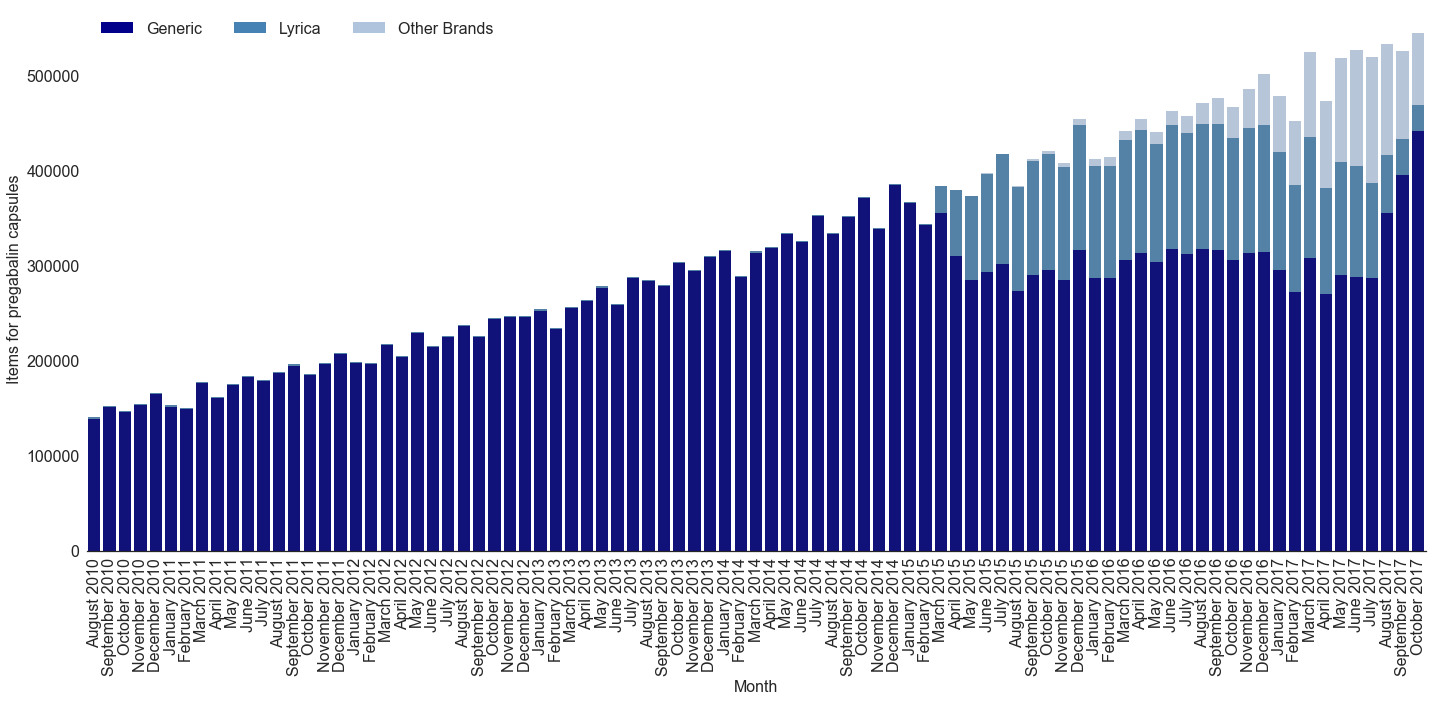

In [6]:
#Create stacked graph in Seaborn, using overlayed plots
#setup style and size
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})
#Plot 1 - "All items"  - will show "other brands" in final plot
ax = sns.barplot(x="month_string", y="all_items",data=overall_df,color = "lightsteelblue")
#Plot 2 - overlay - "generic_and_lyrica" series  - will show Lyrica in final plot
middle_plot = sns.barplot(x="month_string", y="lyrica_and_generic",data=overall_df, color = "steelblue")
#Plot 3 - overlay - "generic" series - shows generic in final plot
bottom_plot = sns.barplot(x="month_string", y="generic_items",data=overall_df, color = "darkblue")

#create legend
topbar = plt.Rectangle((0,0),1,1,fc="lightsteelblue", edgecolor = 'none')
middlebar = plt.Rectangle((0,0),1,1,fc="steelblue", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='darkblue',  edgecolor = 'none')
l = plt.legend([bottombar, middlebar, topbar], ['Generic', 'Lyrica', 'Other Brands'], loc=0, ncol = 3, prop={'size':16})
l.draw_frame(False)

#axes formatting
sns.despine(left=True)
plt.xticks(rotation=90)
bottom_plot.set_ylabel("Items for pregabalin capsules")
bottom_plot.set_xlabel("Month")
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)

### Create timeseries for CCGs and practice deciles of percentage of pregabalin as Lyrica

In [7]:
#create deciles for practices
x = np.arange(0.1, 1, 0.1)
practice_deciles = practice_df.groupby('period')['lyrica_percent'].quantile(x)
practice_deciles_df=pd.DataFrame(practice_deciles)
practice_deciles_df=practice_deciles_df.unstack().reset_index()

#create deciles for CCGs
x = np.arange(0.1, 1, 0.1)
ccg_deciles = ccg_df.groupby('period')['lyrica_percent'].quantile(x)
ccg_deciles_df=pd.DataFrame(ccg_deciles)
ccg_deciles_df=ccg_deciles_df.unstack().reset_index()

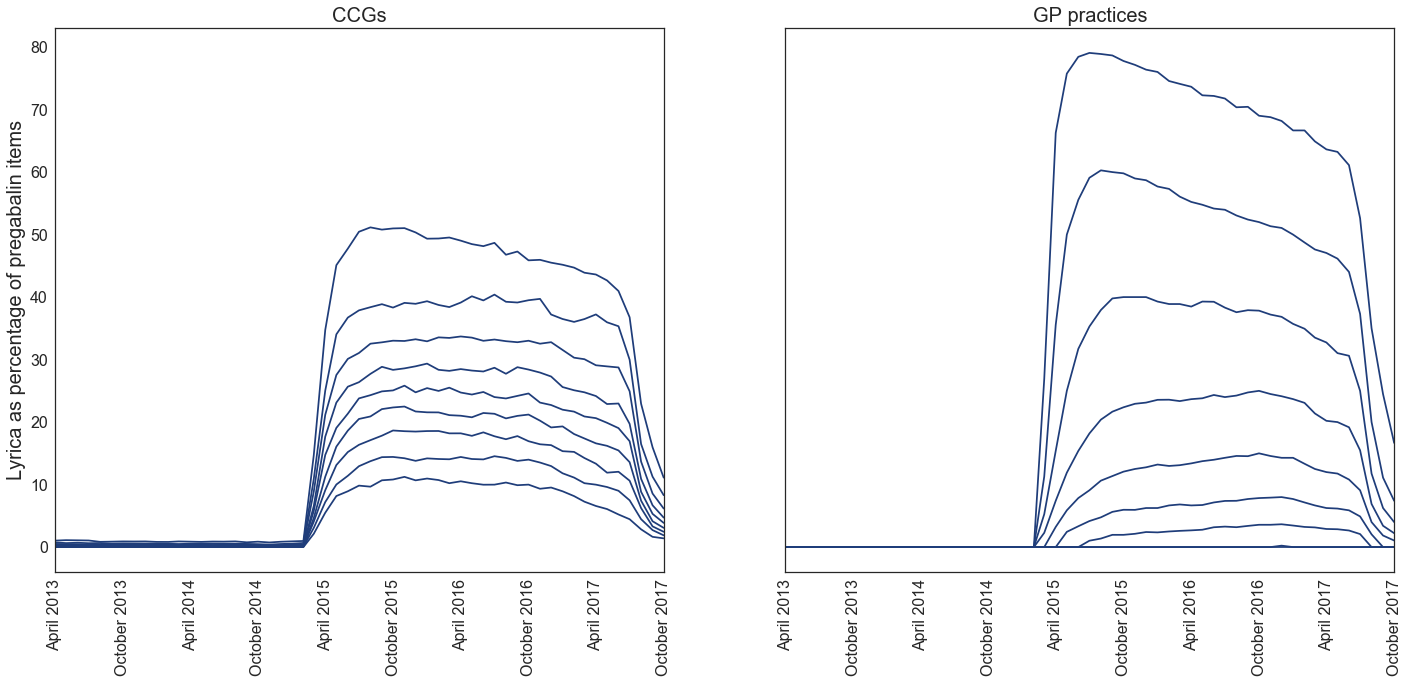

In [8]:
# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(24,10))
ax1.plot_date (ccg_deciles_df.period, 100*ccg_deciles_df.lyrica_percent, linestyle ="solid", marker ="", color ='#1f3d7a' )
ax1.set_title('CCGs', size=20)
#ax1.xticks(rotation=90)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
#fig.autofmt_xdate(rotation=90)
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%B %Y'))
ax1.set_xlim('2013-04-01','2017-10-01')
ax1.yaxis.set_label_text("Lyrica as percentage of pregabalin items", size=20)
ax1.tick_params(labelsize=16)

ax2.plot_date (practice_deciles_df.period, 100*practice_deciles_df.lyrica_percent, linestyle ="solid", marker ="", color ='#1f3d7a')
ax2.set_title('GP practices', size=20)
#ax1.xticks(rotation=90)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)
#fig.autofmt_xdate(rotation=90)
ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%B %Y'))
ax2.set_xlim('2013-04-01','2017-10-01')
ax2.tick_params(labelsize=16)
#ax2.set_xlabel(1, fontsize=50)

## Assessing the financial impact of possible Lyrica patent invalidity

In September 2015 the patent claim for Lyrica for neuropathic pain was found to be invalid by a UK Court. This was upheld on appeal in October 2016, and is due to be heard at the UK Supreme Court in early 2018.

If the Supreme Court agrees with the ruling that the neuropathic pain patent is invalid, then it could be argued that the NHS has continued to pay for the cost of the patent product (Lyrica) rather than a cheaper generic version.

There are two possible dates for this theoretical additional cost to be calculated from: 1) September 2015 (the date of the original ruling) 2) August 2014 (the first full month after the marketing exclusivity for Lyrica ended).

As the price of generic pregabalin was fixed in the Drug Tariff as Lyrica until August 2017 (the month after the disputed patent ended), it did not matter, from a cost perspective, whether generic or branded pregabalin was prescribed up until the tariff changed

### Assumptions made

1. Before the NHS England letter to GPs, pregabalin prescribing was approximately 99.5% generic.  We have assumed that prescribing of pregabalin, including Lyrica and all branded generics would revert to generic prescribing.
2. If pregabalin had been fully available generically before August 2017, the Drug Tariff prices would have been the same in those earlier months than at August 2017
3. The data calculated is for all FP10 data for England, including any prescribing from other providers which would have been charged at the same reimbursement rate as primary care.
4. The calculations include a reduction of the mean "National Average Discount Percentage", which is what the NHS paid, as opposed to the NHS list price.  This was calculated as 7.49%

### Obtaining data from BigQuery

In [9]:
pregabalin_df = pd.read_gbq("""
SELECT
  month AS period,
  (CASE SUBSTR(bnf_code,14,2)
      WHEN 'AA' THEN '25mg capsules'
      WHEN 'AB' THEN '50mg capsules'
      WHEN 'AC' THEN '75mg capsules'
      WHEN 'AD' THEN '100mg capsules'
      WHEN 'AE' THEN '150mg capsules'
      WHEN 'AF' THEN '200mg capsules'
      WHEN 'AI' THEN '225mg capsules'
      WHEN 'AG' THEN '300mg capsules'
      ELSE NULL END) AS strength,
  SUM(quantity) AS quantity,
  SUM(net_cost) AS nic
FROM
ebmdatalab.richard.pregabalin_data
GROUP BY
  period,
  strength
ORDER BY
  period
""", projectid, dialect='standard')

Requesting query... ok.
Job ID: job_KNO0gU3qy2j85acMHHWS9PRQaf6_
Query running...
Query done.
Cache hit.

Retrieving results...
Got 696 rows.

Total time taken 0.99 s.
Finished at 2017-12-19 15:23:26.


### Calculate the estimated impact per month

In [10]:
#create period as index
pregabalin_df.index = pregabalin_df['period']
del pregabalin_df['period']

#define dt_ppu to calculate cost per capsule for each strength as per cost and pack size in August 2017 Drug Tariff
def dt_ppu(c):
    if c['strength'] == '25mg capsules':
        return 1.87/56
    if c['strength'] == '50mg capsules':
        return 2.28/84
    if c['strength'] == '75mg capsules':
        return 2.03/56
    if c['strength'] == '100mg capsules':
        return 2.98/84
    if c['strength'] == '150mg capsules':
        return 2.29/56
    if c['strength'] == '200mg capsules':
        return 3.60/84
    if c['strength'] == '225mg capsules':
        return 3.11/56
    if c['strength'] == '300mg capsules':
        return 4.17/56
    else:
        return 0

#apply cost per capsule to dataframe
pregabalin_df['dt_ppu'] = pregabalin_df.apply(dt_ppu, axis=1)
#calculate the estimated NIC @ August 2017 DT prices by multiplying quantity of capsule by price per unit
pregabalin_df['dt_nic']=pregabalin_df['quantity']*pregabalin_df['dt_ppu']
#calculate the difference in actual and estimated NIC
pregabalin_df['nic_difference']=(pregabalin_df['nic']-pregabalin_df['dt_nic'])
#calculate the estimated actual cost difference by applying 7.49% discount
pregabalin_df['act_cost_difference']=(pregabalin_df['nic_difference']*.9251)

### Estimated impact from September 2015 - July 2017

In [11]:
#create new dataframe by filtering dates
sep15_df=pregabalin_df.loc['2015-09-01':'2017-07-01']
sep15_df.is_copy = None
#groupby each capsule strength
sep15_gp_df=sep15_df.groupby(['strength'])['nic','dt_nic','nic_difference','act_cost_difference'].sum()
#create totals for 100% and 99.5%
sep15_gp_df.loc['Total']=sep15_gp_df.sum(axis=0)
sep15_gp_df.loc['Total at 99.5%']=.995*sep15_gp_df.loc['Total']
#format numbers as currency
sep15_gp_df['nic'] = sep15_gp_df['nic'].map('£{:,.0f}'.format) 
sep15_gp_df['dt_nic'] = sep15_gp_df['dt_nic'].map('£{:,.0f}'.format)
sep15_gp_df['nic_difference'] = sep15_gp_df['nic_difference'].map('£{:,.0f}'.format)
sep15_gp_df['act_cost_difference'] = sep15_gp_df['act_cost_difference'].map('£{:,.0f}'.format) 
#tidy up column names for print
sep15_gp_df.rename(columns={'nic':'NIC', 'dt_nic':'Estimated NIC at August 2017 Drug Tariff', 'nic_difference':'Difference in NIC', 'act_cost_difference':'Difference in Actual Cost'})

,NIC,Estimated NIC at August 2017 Drug Tariff,Difference in NIC,Difference in Actual Cost
strength,,,,
100mg capsules,"£68,695,702","£2,189,943","£66,505,759","£61,524,477"
150mg capsules,"£115,435,814","£4,239,728","£111,196,086","£102,867,499"
200mg capsules,"£35,440,351","£1,370,611","£34,069,740","£31,517,916"
225mg capsules,"£13,479,894","£678,648","£12,801,246","£11,842,433"
25mg capsules,"£57,044,936","£1,718,360","£55,326,577","£51,182,616"
300mg capsules,"£93,056,786","£6,247,685","£86,809,101","£80,307,099"
50mg capsules,"£82,377,344","£2,010,118","£80,367,227","£74,347,721"
75mg capsules,"£125,494,810","£4,084,019","£121,410,791","£112,317,123"
Total,"£591,025,637","£22,539,112","£568,486,526","£525,906,885"


### Estimated impact from August 2014 - July 2017

In [12]:
#create new dataframe by filtering dates
aug14_df=pregabalin_df.loc['2014-07-01':'2017-07-01']
aug14_df.is_copy = None
#groupby each capsule strength
aug14_gp_df=aug14_df.groupby(['strength'])['nic','dt_nic','nic_difference','act_cost_difference'].sum()
#create totals for 100% and 99.5%
aug14_gp_df.loc['Total']=aug14_gp_df.sum(axis=0)
aug14_gp_df.loc['Total at 99.5%']=.995*aug14_gp_df.loc['Total']
#format numbers as currency
aug14_gp_df['nic'] = aug14_gp_df['nic'].map('£{:,.0f}'.format) 
aug14_gp_df['dt_nic'] = aug14_gp_df['dt_nic'].map('£{:,.0f}'.format)
aug14_gp_df['nic_difference'] = aug14_gp_df['nic_difference'].map('£{:,.0f}'.format)
aug14_gp_df['act_cost_difference'] = aug14_gp_df['act_cost_difference'].map('£{:,.0f}'.format) 
aug14_gp_df.rename(columns={'nic':'NIC', 'dt_nic':'Estimated NIC at August 2017 Drug Tariff', 'nic_difference':'Difference in NIC', 'act_cost_difference':'Difference in Actual Cost'})

,NIC,Estimated NIC at August 2017 Drug Tariff,Difference in NIC,Difference in Actual Cost
strength,,,,
100mg capsules,"£103,679,552","£3,269,294","£100,410,259","£92,889,530"
150mg capsules,"£177,238,107","£6,437,641","£170,800,466","£158,007,511"
200mg capsules,"£53,187,524","£2,032,095","£51,155,429","£47,323,887"
225mg capsules,"£19,854,412","£986,525","£18,867,887","£17,454,682"
25mg capsules,"£86,563,013","£2,575,600","£83,987,413","£77,696,755"
300mg capsules,"£138,916,243","£9,217,547","£129,698,696","£119,984,264"
50mg capsules,"£126,258,073","£3,045,962","£123,212,111","£113,983,523"
75mg capsules,"£195,052,421","£6,276,857","£188,775,564","£174,636,274"
Total,"£900,749,345","£33,841,521","£866,907,823","£801,976,427"
